## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

### Import Modules & Set-Up

In [26]:
# basic
import pandas as pd
import numpy as np
import xgboost as xgb

# viz
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor

# custom config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [30]:
# MPL Settings
%config InlineBackend.figure_format = 'svg'

mpl.rcParams["font.family"] = "Arial"
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams["figure.figsize"] = [10, 8]
%matplotlib inline

grey = '#808080'
darkgrey = '#505050'
# (http://www.color-hex.com/color/505050)

mpl.rcParams['axes.linewidth'] = 0.3
mpl.rcParams['axes.edgecolor'] = grey
mpl.rcParams['xtick.color'] = grey
mpl.rcParams['ytick.color'] = grey
mpl.rcParams['text.color'] = darkgrey
mpl.rcParams['axes.labelcolor'] = darkgrey

In [3]:
csv_loc = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'

In [4]:
# !curl {csv_loc} -o AB_NYC_2019.csv

In [5]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [6]:
# Log Transformation of 'price'
df.price = np.log1p(df.copy().price.values)

In [7]:
# train/validation/test split
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train.price.values
y_val = df_val.price.values
df_train_orig = df_train.copy()
del df_train['price']
del df_val['price']

# Checking size
len(df_train), len(df_val), len(df_test)
len(df_train) + len(df_val) + len(df_test) == len(df)

# Checking target
y_train[:5]

(29337, 9779, 9779)

True

array([4.7095302 , 4.26267988, 6.13339804, 4.60517019, 7.60140233])

Now, use `DictVectorizer` to turn train and validation into matrices:

In [8]:
def feature_dict(data):
    data = data.fillna(0)
    feat_dict = data.to_dict(orient='records')
    return feat_dict

dv = DictVectorizer(sparse=False)


In [10]:
train_dict = feature_dict(df_train)
val_dict = feature_dict(df_val)

dv.fit(train_dict)
dv.transform(train_dict)
dv.get_feature_names()

DictVectorizer(sparse=False)

array([[363.     ,   1.     ,  40.76434, ...,   1.     ,   0.     ,
          0.     ],
       [  0.     ,   1.     ,  40.73442, ...,   0.     ,   1.     ,
          0.     ],
       [113.     ,   5.     ,  40.66359, ...,   1.     ,   0.     ,
          0.     ],
       ...,
       [178.     ,   2.     ,  40.69034, ...,   0.     ,   1.     ,
          0.     ],
       [  0.     ,   1.     ,  40.76324, ...,   1.     ,   0.     ,
          0.     ],
       [362.     ,  23.     ,  40.74563, ...,   1.     ,   0.     ,
          0.     ]])

['availability_365',
 'calculated_host_listings_count',
 'latitude',
 'longitude',
 'minimum_nights',
 'neighbourhood_group=Bronx',
 'neighbourhood_group=Brooklyn',
 'neighbourhood_group=Manhattan',
 'neighbourhood_group=Queens',
 'neighbourhood_group=Staten Island',
 'number_of_reviews',
 'reviews_per_month',
 'room_type=Entire home/apt',
 'room_type=Private room',
 'room_type=Shared room']

In [11]:
X_train = dv.transform(train_dict)
X_train.shape

X_train[:5]
y_train[:5]

X_val = dv.transform(val_dict)

(29337, 15)

array([[ 3.630000e+02,  1.000000e+00,  4.076434e+01, -7.392132e+01,
         4.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         1.000000e+00,  0.000000e+00,  3.000000e+01,  3.200000e-01,
         1.000000e+00,  0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  1.000000e+00,  4.073442e+01, -7.395854e+01,
         5.000000e+00,  0.000000e+00,  1.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  2.000000e+00,  1.600000e-01,
         0.000000e+00,  1.000000e+00,  0.000000e+00],
       [ 1.130000e+02,  5.000000e+00,  4.066359e+01, -7.399487e+01,
         1.000000e+00,  0.000000e+00,  1.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  3.300000e+01,  2.750000e+00,
         1.000000e+00,  0.000000e+00,  0.000000e+00],
       [ 3.620000e+02,  2.000000e+00,  4.063766e+01, -7.402626e+01,
         3.000000e+00,  0.000000e+00,  1.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  1.000000e+00,  1.200000e-01,
         0.000000e+00,

array([4.7095302 , 4.26267988, 6.13339804, 4.60517019, 7.60140233])

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [12]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

In [13]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Q1 answer: Therefore room_type is used to split this decision stump.

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [14]:
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

In [15]:
y_pred = rf.predict(X_val)

y_val[:5]
y_pred[:5]

array([5.01063529, 3.93182563, 5.01727984, 5.420535  , 3.71357207])

array([4.87505509, 4.79647079, 5.38940092, 6.02198843, 4.05875443])

In [16]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    res = np.sqrt(mse)
    return res

In [17]:
rmse(y_val, y_pred)

0.4615632303514057

Q2: RMSE of model closed to 0.459

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [18]:
scores = []

for r in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=r, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse_score = rmse(y_val, y_pred)
    scores.append((r, rmse_score))


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=40, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=60, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=70, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=80, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=90, n_jobs=-1, random_state=1)

RandomForestRegressor(n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=110, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=120, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=130, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=140, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=160, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=170, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=180, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=190, n_jobs=-1, random_state=1)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=1)

[(10, 0.46156323035140573),
 (20, 0.44818440372465634),
 (30, 0.445534982591036),
 (40, 0.44363704006865734),
 (50, 0.44232521586937884)]

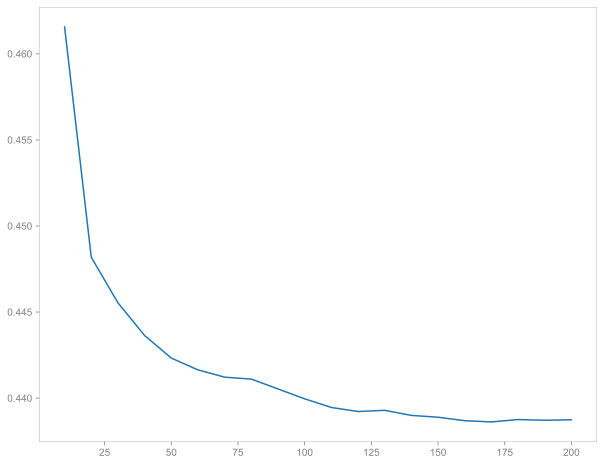

In [28]:
scores[:5]

df_scores = pd.DataFrame(scores, columns=['No_Estimators', 'RMSE'])

fig = plt.figure(figsize=(10, 8))

plt.plot(df_scores.No_Estimators, df_scores.RMSE,)


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

Q3: Seems to stop meaningfully improving around 120 estimators.

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [29]:
scores = []

depths = [10, 15, 20, 25]

for d in depths:
    for r in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=r, random_state=1, n_jobs=-1, max_depth=d)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse_score = rmse(y_val, y_pred)
        scores.append((d, r, rmse_score))

RandomForestRegressor(max_depth=10, n_estimators=10, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=20, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=40, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=60, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=70, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=80, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=90, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=110, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=120, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=130, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=140, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=150, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=160, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=170, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=180, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=190, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=10, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=20, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=30, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=40, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=50, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=60, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=70, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=80, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=90, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=110, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=120, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=130, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=140, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=150, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=160, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=170, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=180, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=190, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=20, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=30, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=40, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=50, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=60, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=70, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=80, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=90, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=110, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=120, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=130, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=140, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=150, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=160, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=170, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=180, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=190, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=10, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=20, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=30, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=40, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=50, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=60, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=70, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=80, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=90, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=110, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=120, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=130, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=140, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=150, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=160, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=170, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=180, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=190, n_jobs=-1, random_state=1)

RandomForestRegressor(max_depth=25, n_estimators=200, n_jobs=-1, random_state=1)

,Max_Depth,No_Estimators,RMSE
68,25,90,0.440330
69,25,100,0.439898
70,25,110,0.439477
71,25,120,0.439243
72,25,130,0.439286
73,25,140,0.439027
74,25,150,0.438984
75,25,160,0.438769
76,25,170,0.438696
77,25,180,0.438848


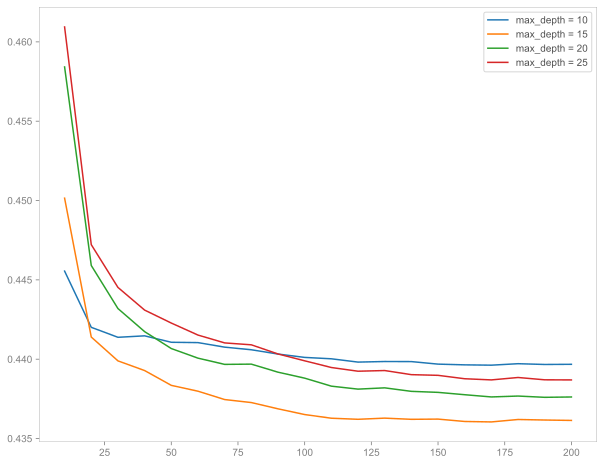

In [45]:
df_scores = pd.DataFrame(scores, columns=['Max_Depth', 'No_Estimators', 'RMSE'])

df_scores.tail(12)

fig = plt.figure(figsize=(10, 8))

for d in depths:
    df_sub = df_scores[df_scores.Max_Depth==d]
    plt.plot(df_sub.No_Estimators, df_sub.RMSE, label=f'max_depth = {d}')

plt.legend()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

Q4: best max_depth seems to be 15.

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [32]:
rft = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rft.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

In [33]:
rft.feature_importances_

sorted(zip(rft.feature_importances_.round(5), dv.get_feature_names()),reverse=True)


array([7.62639474e-02, 3.01019255e-02, 1.52775354e-01, 1.54100960e-01,
       5.32519176e-02, 2.64845849e-04, 9.65959537e-04, 3.40472718e-02,
       1.16609902e-03, 8.40278947e-05, 4.15942415e-02, 5.44303877e-02,
       3.91898194e-01, 4.03202776e-03, 5.02284130e-03])

[(0.3919, 'room_type=Entire home/apt'),
 (0.1541, 'longitude'),
 (0.15278, 'latitude'),
 (0.07626, 'availability_365'),
 (0.05443, 'reviews_per_month'),
 (0.05325, 'minimum_nights'),
 (0.04159, 'number_of_reviews'),
 (0.03405, 'neighbourhood_group=Manhattan'),
 (0.0301, 'calculated_host_listings_count'),
 (0.00502, 'room_type=Shared room'),
 (0.00403, 'room_type=Private room'),
 (0.00117, 'neighbourhood_group=Queens'),
 (0.00097, 'neighbourhood_group=Brooklyn'),
 (0.00026, 'neighbourhood_group=Bronx'),
 (8e-05, 'neighbourhood_group=Staten Island')]

Q5: 'room_type=Entire home/apt'

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [34]:
features = dv.get_feature_names()
features

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

['availability_365',
 'calculated_host_listings_count',
 'latitude',
 'longitude',
 'minimum_nights',
 'neighbourhood_group=Bronx',
 'neighbourhood_group=Brooklyn',
 'neighbourhood_group=Manhattan',
 'neighbourhood_group=Queens',
 'neighbourhood_group=Staten Island',
 'number_of_reviews',
 'reviews_per_month',
 'room_type=Entire home/apt',
 'room_type=Private room',
 'room_type=Shared room']

In [35]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [36]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

In [37]:
print(output)

[0]	train-rmse:3.02752	val-rmse:3.02415
[10]	train-rmse:0.43912	val-rmse:0.44981
[20]	train-rmse:0.41716	val-rmse:0.43691
[30]	train-rmse:0.40712	val-rmse:0.43543
[40]	train-rmse:0.40103	val-rmse:0.43466
[50]	train-rmse:0.39446	val-rmse:0.43384
[60]	train-rmse:0.38743	val-rmse:0.43404
[70]	train-rmse:0.38117	val-rmse:0.43467
[80]	train-rmse:0.37668	val-rmse:0.43526
[90]	train-rmse:0.36998	val-rmse:0.43539
[99]	train-rmse:0.36478	val-rmse:0.43621



Now change `eta` first to `0.1` and then to `0.01`

In [38]:

def parse_xgb_output(output):
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(val)

    return tree, aucs_train, aucs_val

In [40]:
tree, _, rmse_val_eta_03 = parse_xgb_output(output)
print('Scores for 0.3:')
print(min(rmse_val_eta_03))
print(min(zip(rmse_val_eta_03, tree)))

Scores for 0.3:
0.43384
(0.43384, 50)


In [41]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

In [42]:
tree, _, rmse_val_eta_01 = parse_xgb_output(output)
print('Scores for 0.1:')
print(min(rmse_val_eta_01))
print(min(zip(rmse_val_eta_01, tree)))

Scores for 0.1:
0.4325
(0.4325, 99)


In [43]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

In [44]:
tree, _, rmse_val_eta_001 = parse_xgb_output(output)
print('Scores for 0.01:')
print(min(rmse_val_eta_001))
print(min(zip(rmse_val_eta_001, tree)))

Scores for 0.01:
1.63045
(1.63045, 99)


Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

Q6: The best ETA score is therefore produced by 0.1

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

